# Importamos librerías - Creamos el dataframe de pericias

In [50]:
import pandas as pd
import numpy as np
from pprint import pprint

df = pd.read_csv('pericias_medicas.csv', sep=',',  encoding='utf-8')
#convierte en string los datos de la columna text
df1 = df['text'].apply(str)

3806

## Limpieza de texto

In [51]:
# Limpieza de texto
# Primera etapa de la limpieza de texto
import re, string, unicodedata
'''
Se hace la eliminacion de texto entre corchetes, acentos, signos de puntuacion (excepto . y :), palabras con numeros.
Se eliminan los espacios de sobra
Se eliminan \r, \t, \v, \f, \a
'''
def limpiarTexto1(txt: str, bert=False, nums=False) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))

    '''
    Eliminamos caracteres especiales: tabulador orizontal(\t), tabulador vertical(\v), 
    retorno de carro(\r), avance de pagina(\f), 
    caracter de retroceso: Marca el límite de una palabra(\b), 
    '''
    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt
df1 = df1.apply(str)
df1 = df1.apply(limpiarTexto1)

In [52]:
# Segunda fase de limpieza
# Se eliminan todos los elementos que meten ruido al texto y que no fueron eliminados en la fase de limpieza 1.
import re

def limpiarTexto2(text):
    text = re.sub('^ ',' ',text)
    text = re.sub('\n +\n','\n',text)
    text = re.sub(' +\n\n','\n',text)
    text = re.sub('\n\n+','\n',text)
    text = re.sub(' \n','\n',text)
    text = re.sub('\d\n','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('\u200b\n','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('\d+-\d+','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('[nN]º|[nN][. ]º','',text)
    text = re.sub('[º<>/]','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('[a-zA-z-.]+@[a-zA-Z]+.com','',text)
    return text

df1 = df1.apply(limpiarTexto2)

In [53]:
# Tercera fase de limpieza
# Eliminamos las lineas que no son de utilidad para el analisis o que van a afectar los resultados del mismo.
# Ejemplo de linea eliminada: las lineas que comienzan con "Se encuentra contestada en....."
import re

def limpiarTexto3(text):
    text = re.sub('[a-z1-9.]+[).-] [s|S]e encuentra contestad[a|o] .+[. \n]','',text)
    text = re.sub('[0-9]+[. ]+[yY]a fue contestado.+[.\n]','',text)
    text = re.sub('[fF]oja [1-9].+\n', '', text)
    text = re.sub('[pP]regunta[ 0-9]+[)].+\n|[rR]espuesta[ 0-9]+[)].+\n','',text)#elimina oraciones comenzadas en preguta/respuesta.
    text = re.sub('V[. ]+[S\n\.]+', '', text)
    #text = re.sub('[IV]+.[A-Z]{1,3}[\n.]', '', text)
    text = re.sub('[I][.][P][.]','',text)
    text = re.sub('[I][.][T][.]','',text)
    text = re.sub('[I][.][A][.]','',text)
    text = re.sub('[I][.][L][.]','',text)
    text = re.sub('[I][.][B][.]','',text)
    text = re.sub('[I][.][N][.]','',text)
    text = re.sub('[I][.][V][.]','',text)
    text = re.sub('[V][.][M][.]','',text)
    text = re.sub('[V][.][A][.]','',text)

    return text

dfLimpio = df1.apply(limpiarTexto3)
dfLimpio = dfLimpio.apply(limpiarTexto2)
#pprint(dfLimpio[0])

# Busqueda de titulos

In [54]:
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8:
            titulosMayusculasEncontrados.append(m.group())

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfLimpio:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)

## Eliminación de stopwords. Nueva limpieza

In [56]:
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

# elimino stopwords
def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return texto

def limpiarTitulos(text):
    text = text.lower()
    text = re.sub(r'\n','',text)
    text = re.sub(r'[a-z]\.[a-z]\.','',text)
    text = re.sub(r'(i{2,3}|iv|vi{1,3}|ix)','',text)
    text = re.sub(r'\W',' ',text)    
    text = re.sub(r'\d+','',text)
    text = re.sub(r' [a-z] ','',text)
    
    
    return text

# elimino stopwords y hago una última limpieza
titulosMayusculasStop = limpiarTitulos(str(titulosMayusculas))
titulosMayusculasStop = remove_stops(str(titulosMayusculasStop))

# FASE DE ANALISIS

# N-Gramas

### Tokens

In [ ]:
# FRECUENCIA DE TOKENS
# Metodo para contar la frecuencia de palabras de los tokens en titulos
import pandas as pd
dfTitulosMayusculas = pd.DataFrame(titulosMayusculasStop,columns=['tokens'])
dfTitulosMayusculas.value_counts()

In [ ]:
#Frecuencia de los tokens en los titulos.
import pandas as pd
FrecTitulosMayusculas = pd.DataFrame(titulosMayusculasStop)
cantMay = FrecTitulosMayusculas.value_counts()
print(cantMay[:15])


In [ ]:
#Dataframe de tokens en titulos en mayusculas y sus frecuencias.
import pandas as pd
dfFrecTitulosMayusculas = pd.DataFrame(cantMay,columns=['frecuencia'])
dfFrecTitulosMayusculas['frecuencia']

### Tokens

In [82]:
# METODO 1 - BIGRAMAS DE TITULOS EN MAYUSCULAS

#bigrama de títulos con mayúsculas.
tokenMay=(list(nltk.ngrams(titulosMayusculasStop,1)))
tokenMay

13180

### Bigramas

In [ ]:
# METODO 1 - BIGRAMAS DE TITULOS EN MAYUSCULAS

#bigrama de títulos con mayúsculas.
bigramaMay=(list(nltk.ngrams(titulosMayusculasStop,2)))
bigramaMay

In [61]:
# Creo un archivo csv para utilizar en la generacion de n-gramas

#Se exporta el dataframe a un archivo csv
dfTitulosMayusculas.to_csv('titTokenEnMayusculas.csv', index=False, sep=';') 

In [ ]:
# METODO 2 - BIGRAMAS DE TITULOS EN MAYUSCULAS ---> RECOMENDADO

# Creacion de bigramas de titulos en mayusculas
f = open('titTokenEnMayusculas.csv')
raw = f.read()

token = nltk.word_tokenize(raw)

bgsMayusculas = nltk.bigrams(token)

bgsMayusculaFdist = nltk.FreqDist(bgsMayusculas)
for k,v in bgsMayusculaFdist.items():
    print(f'{k} {v}')

In [ ]:
# Mostrar los bigramas de mayor frecuencia
bgsMayusculaFdist.most_common(15)

In [ ]:
# Creacion de dataframe de bigramas de titulos en mayusculas
import pandas as pd
bgsFrec=[]
for k,v in bgsMayusculaFdist.items():
    bgsFrec.append((k,v))

dfBgsMayusculas = pd.DataFrame(bgsFrec,columns=['bigrama','frecuencia'])
dfBgsMayusculas

In [ ]:
bgsMayusculaFdist.plot(15) #Ver las 15 colocaciones más frecuentes

### Trigrama

In [ ]:
# METODO 1 - TRIGRAMAS DE TITULOS EN MAYUSCULAS

#trigrama de títulos con mayúsculas.
trigramaMay1=(list(nltk.ngrams(titulosMayusculasStop,3)))
trigramaMay1

In [ ]:
# METODO 2 - TRIGRAMAS DE TITULOS EN MAYUSCULAS ---> RECOMENDADO

# Creacion de trigramas de titulos en mayusculas
f = open('titTokenEnMayusculas.csv')
raw = f.read()

token = nltk.word_tokenize(raw)

trigsMayuscula = nltk.trigrams(token)

trigsMayusculaFdist = nltk.FreqDist(trigsMayuscula)
for k,v in trigsMayusculaFdist.items():
    print(f'{k} {v}')

In [ ]:
# Mostrar los trigramas de mayor frecuencia
trigsMayusculaFdist.most_common(15)


In [ ]:
# Creacion de dataframe de trigramas de titulos en mayusculas
import pandas as pd
trigsFrec=[]
for k,v in trigsMayusculaFdist.items():
    trigsFrec.append((k,v))

dfTrigsMayusculas = pd.DataFrame(trigsFrec,columns=['trigrama','frecuencia'])
dfTrigsMayusculas

In [ ]:
trigsMayusculaFdist.plot(10)

In [96]:
# elimino los stopword de titulos en mayusculas para la nube de palabras
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

# elimino stopwords
def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return texto

def limpiarTitulos(text):
    text = text.lower()
    text = re.sub(r'\n','',text)
    text = re.sub(r'[a-z]\.[a-z]\.','',text)
    text = re.sub(r'(i{2,3}|iv|vi{1,3}|ix)','',text)
    text = re.sub(r'\W',' ',text)    
    text = re.sub(r'\d+','',text)
    text = re.sub(r' [a-z] ','',text)
    
    
    return text
titulosMayusculasSinStop = limpiarTitulos(str(titulosMayusculas))
titulosMayusculasSinStop = remove_stops(str(titulosMayusculasSinStop))

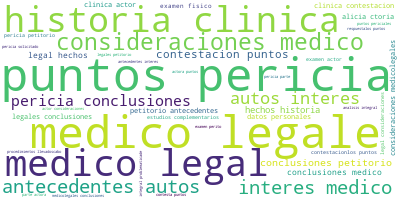

In [97]:
# Import the wordcloud library
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(titulosMayusculasSinStop))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

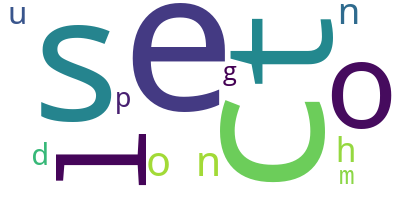

In [102]:
# Import the wordcloud library
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list())

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [109]:

titulosMayusculas.count('CONCLU')

588

In [112]:
titulosMayusculas.count('CONSIDERACIONES')

473